In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import reciprocalspaceship as rs
import scipy.optimize as opt
import gemmi as gm
from tqdm import tqdm
import os

import matplotlib
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15)

import sklearn
from sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn import datasets

In [2]:
from xtal_analysis.xtal_analysis_functions import load_ccp4

#### Specify input parameters

In [3]:
n           = 6
mask_status = 'nomask'
path        = '/Users/alisia/Desktop/SACLA_JUN2021/final_scripts/qweighted_maps/apply_PCA_denoise/'
pdb         = '{}dark.pdb'.format(path)
grid_size   = [150, 180, 216]

In [4]:
def make_matrix_A(path, n):
    
    mapsdic = {}
    
    for m in np.arange(1,n+1):
        
        mapsdic['map%s' % m]               = load_ccp4('{path}/{m}_diff.ccp4'.format(path=path, m=m))[3]
        current_map                        = mapsdic['map%s' % m]
        current_map[np.isnan(current_map)] = 0
        
        print('processing number {}'.format(m))
    
    A = np.row_stack([np.asarray( i ) for i in mapsdic.values()])
    
    print('A matrix shape : ', A.shape)

    print('Centering data')

    A_c = np.zeros(A.shape)
    
    for i in range(0,n):
        A_c[i, :] = A[i, :] - A.mean(axis=0)
        
    print('All done')
    
    return A_c, A.mean(axis=0)

#### (1) Load maps as numpy matrix and check example distribution

In [5]:
A, means = make_matrix_A('{}/input_maps'.format(path), n)

processing number 1
processing number 2
processing number 3
processing number 4
processing number 5
processing number 6
A matrix shape :  (6, 5832000)
Centering data
All done


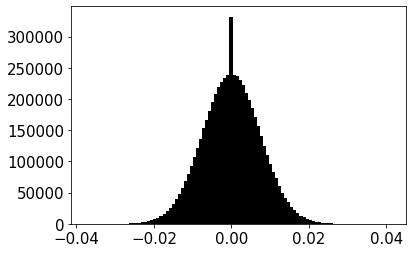

In [6]:
plt.hist(A[1,:], bins=100, color='k')
plt.show()

#### (2) Perform PCA

In [7]:
doPCA  = PCA(svd_solver='full')
pca    = doPCA.fit_transform(A)

In [8]:
ticks  = list(np.arange(n))
S      = doPCA.singular_values_
V      = doPCA.components_
U      = doPCA.fit_transform(A).dot(np.linalg.inv(np.diag(S)))
y      = doPCA.explained_variance_ratio_

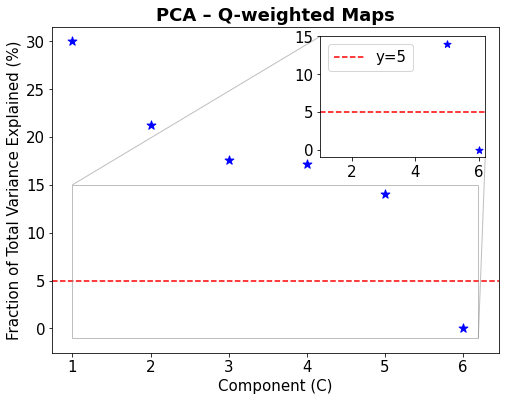

In [9]:
fig, ax = plt.subplots(figsize=(8, 6))
pts = ax.scatter(np.array(ticks)+1, y*100, color='b', marker='*', s=86)
ax.set_xlabel("Component (C)", fontsize=15)
ax.set_ylabel("Fraction of Total Variance Explained (%)", fontsize=15)

# Inset
axins = ax.inset_axes([0.6, 0.6, 0.37, 0.37])
axins.scatter(np.array(ticks)+1, y*100, color='b', marker='*', s=56)
axins.axhline(y=5, color='r', linestyle='--', label='y=5')
axins.legend(fontsize=15)

x1, x2, y1, y2 = 1, 6.2, -1, 15
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
ax.indicate_inset_zoom(axins)
ax.axhline(y=5, color='r', linestyle='--', label='y=2')
ax.set_title('PCA – Q-weighted Maps', fontsize=18, fontweight='bold')

plt.show()

#### (4) Choose number of components to keep and reconstruct maps without noise 

In [10]:
num_components = 5

In [11]:
A_recons = np.matrix(U[:, :num_components]) * np.diag(S[:num_components]) * np.matrix(V[:num_components, :])

for i in range(0,5):
    A_recons[i, :] = A_recons[i, :] + means

In [12]:
og_map   = load_ccp4('{}input_maps/1_diff.ccp4'.format(path))[0]
new_maps = []

for i in np.arange(n):
    new_map = A_recons[i,:]
    new_map = np.array(new_map).flatten()
    new_maps.append(new_map)

for idx, new_map in tqdm(enumerate(new_maps)):
    new_map = np.reshape(new_map, (grid_size[0],grid_size[1],grid_size[2]))

    for point in  og_map.grid:
        u     = og_map.grid.get_point(point.u, point.v, point.w).u
        v     = og_map.grid.get_point(point.u, point.v, point.w).v
        w     = og_map.grid.get_point(point.u, point.v, point.w).w
        value = new_map[u, v, w]

        og_map.grid.set_value(point.u, point.v, point.w, value)
        
    og_map.write_ccp4_map('{path}/output_maps/pca_reconstructed_t{t}_{mask}.map'.format(path=path, t=idx, mask=mask_status))

6it [05:36, 56.04s/it]
